### Invariant measures with small noise
##### - Dan & Vilmer
--------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
import scipy as sp
from mpl_toolkits import mplot3d
rcParams["figure.dpi"] = 400
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

def turn_off_pane_fills(ax):
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False

directory = 'plots/'

In [8]:
def dynamics(X, dt, µ, δ, ε):
    x, y, z = X
    dW = np.random.normal(loc=0, scale=np.sqrt(dt))
    dx = (µ*x - y**2 + 2*z**2 - δ*z)*dt
    dy = y*(x-1)*dt + np.sqrt(2)*ε*dW
    dz = (µ*z + δ*x - 2*x*z)*dt
    dX = np.array([dx, dy, dz])
    return dX

In [3]:
'''Model parameters'''

X0 = np.array([0.5, 0.02, 0.5])
X0_2 = np.array([0.5, 0.0001, 0.5])
X0_3 = np.array([-0.5, -0.2, 0.3])
N = 10000000              
L = 10
dt = 0.001
X = np.zeros((N+1, 3))
X[0, :] = X0_3
µ, δ = 0.01, 1.5


/var/folders/vf/myl_wth151935kby7qdp4ss40000gn/T/ipykernel_6685/3659254907.py:13: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/var/folders/vf/myl_wth151935kby7qdp4ss40000gn/T/ipykernel_6685/3659254907.py:14: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/var/folders/vf/myl_wth151935kby7qdp4ss40000gn/T/ipykernel_6685/3659254907.py:15: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = False


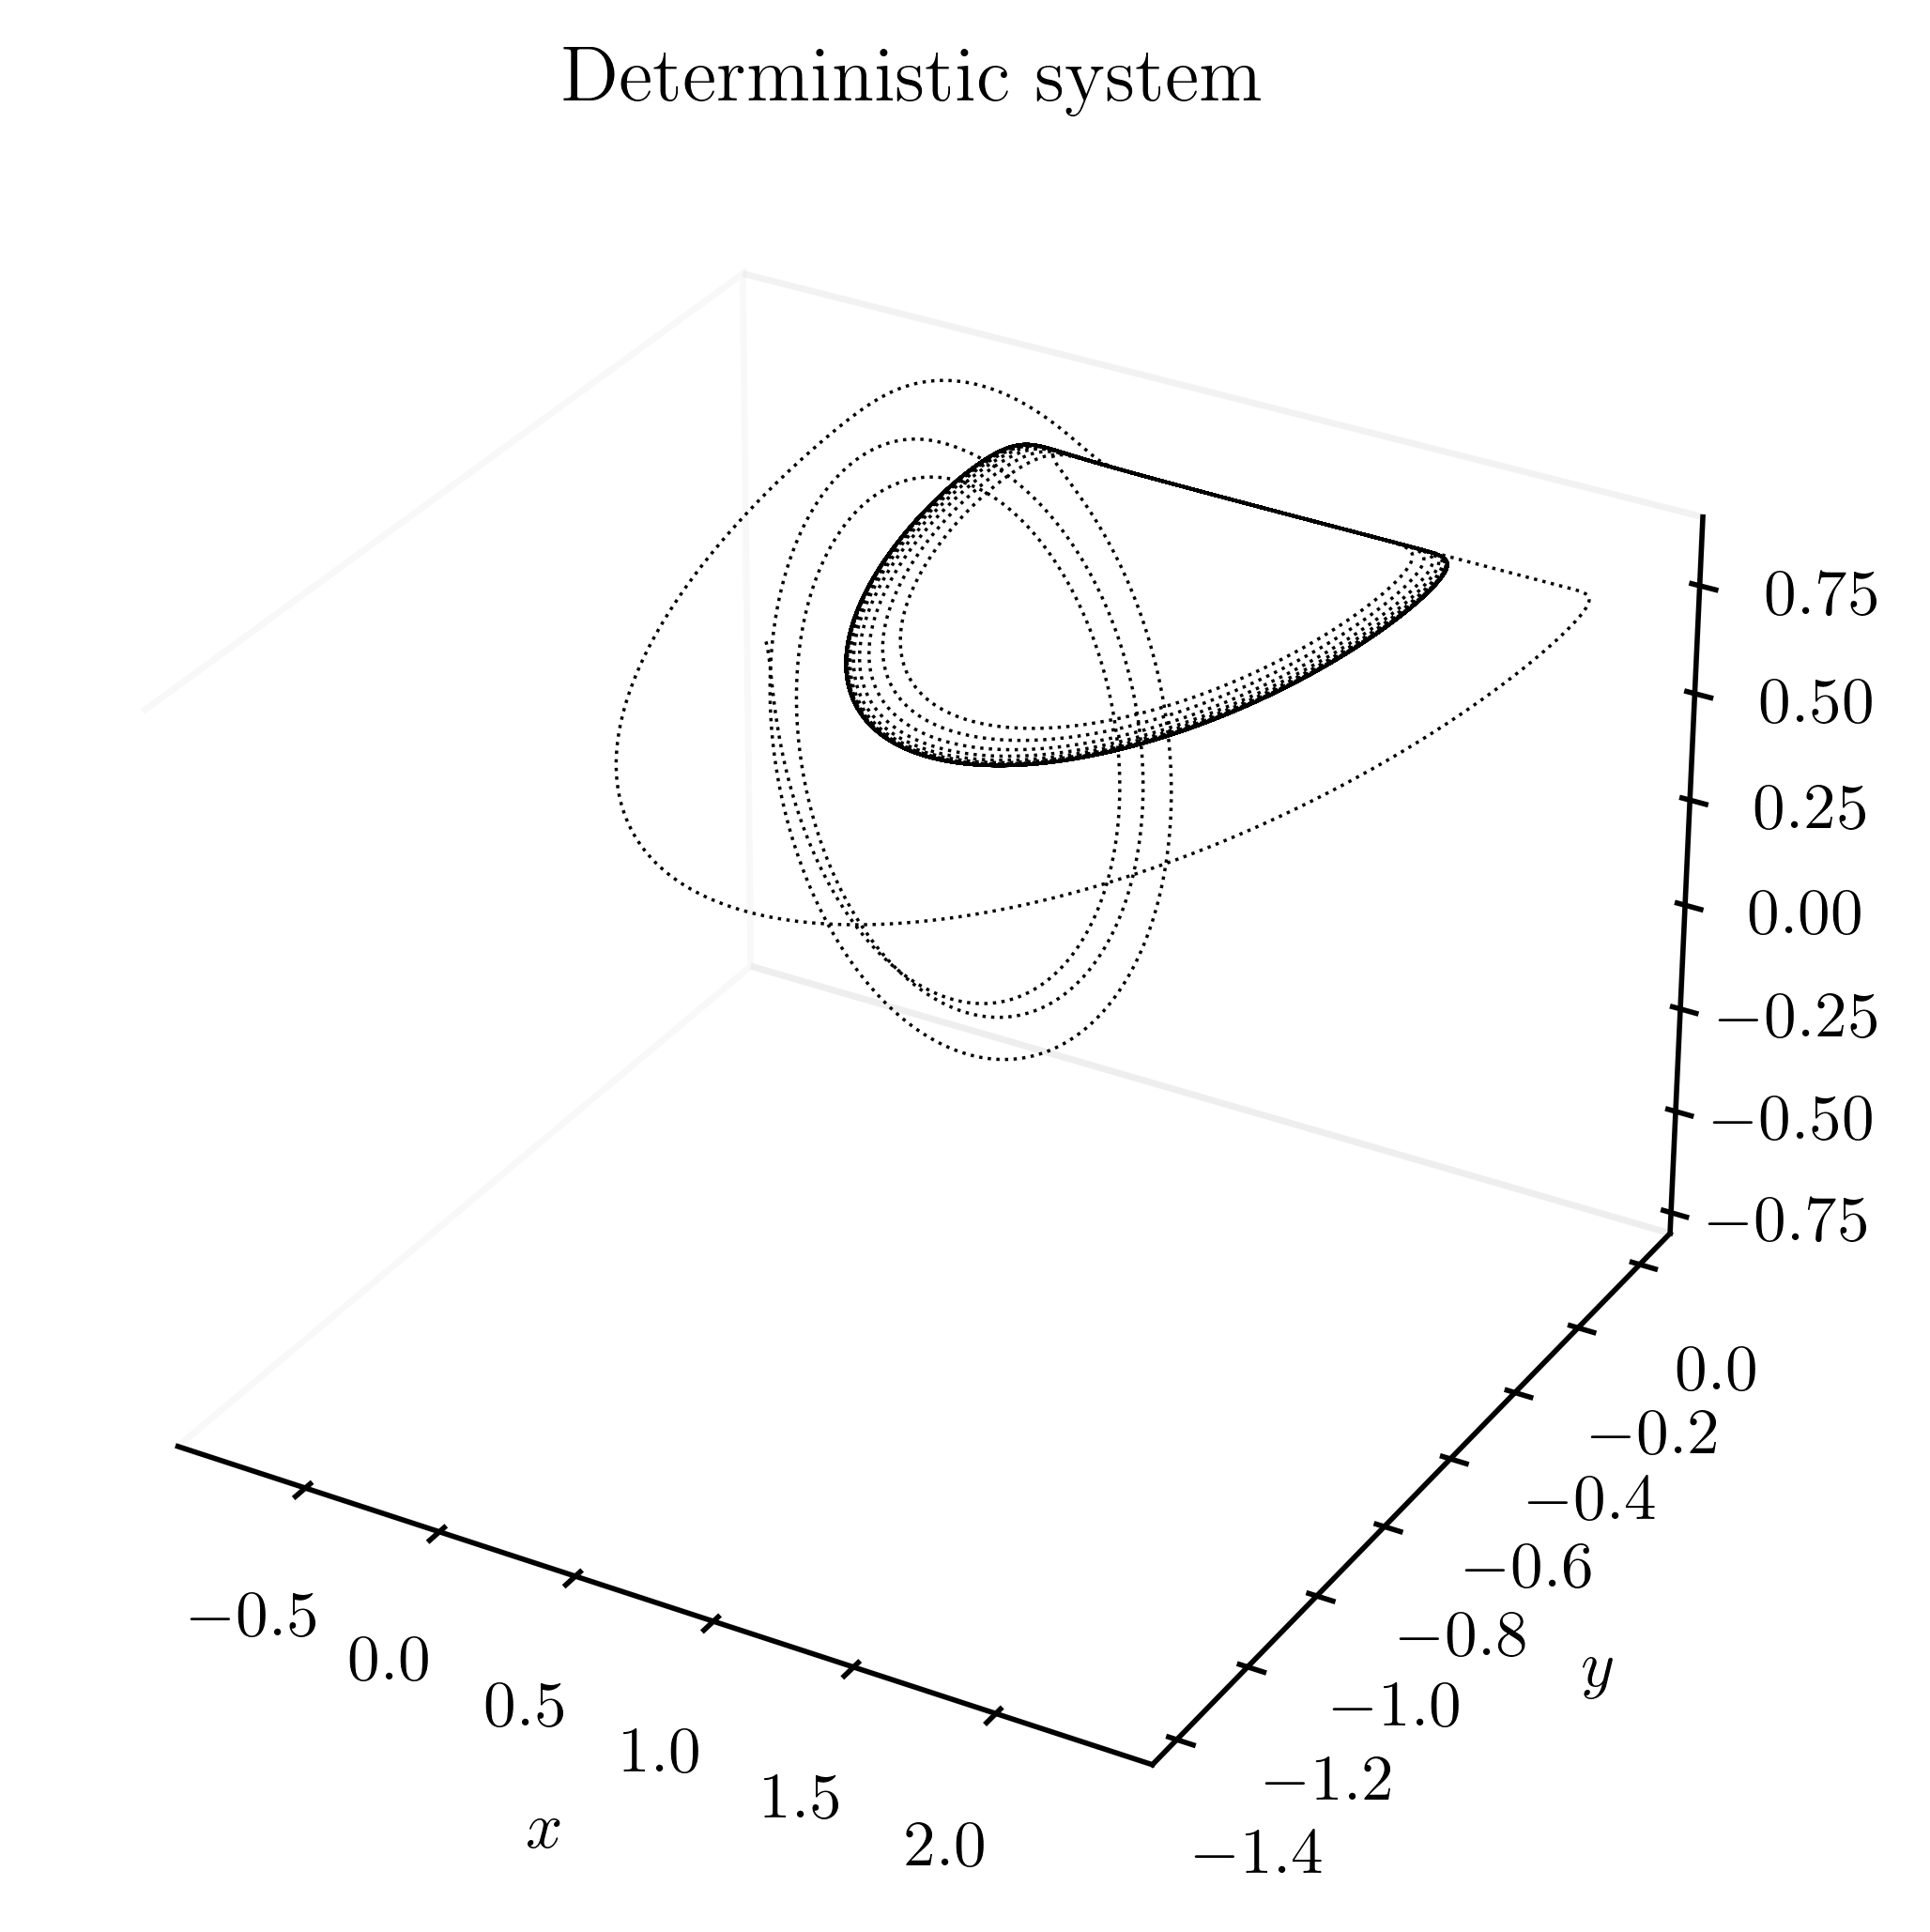

In [5]:
'''Simulation of deterministic system'''
for i in range(N):
    X[i+1, :] = X[i, :] + dynamics(X[i-1, :], dt, µ, δ, 0)
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(X[:, 0], X[:, 1], X[:, 2], color='black', linewidth=0.5, linestyle='dotted')
ax.grid(False)
turn_off_pane_fills(ax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Deterministic system')
fig.savefig(directory + 'deterministic_system.pdf', bbox_inches='tight')


/var/folders/vf/myl_wth151935kby7qdp4ss40000gn/T/ipykernel_6685/3659254907.py:13: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/var/folders/vf/myl_wth151935kby7qdp4ss40000gn/T/ipykernel_6685/3659254907.py:14: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/var/folders/vf/myl_wth151935kby7qdp4ss40000gn/T/ipykernel_6685/3659254907.py:15: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = False


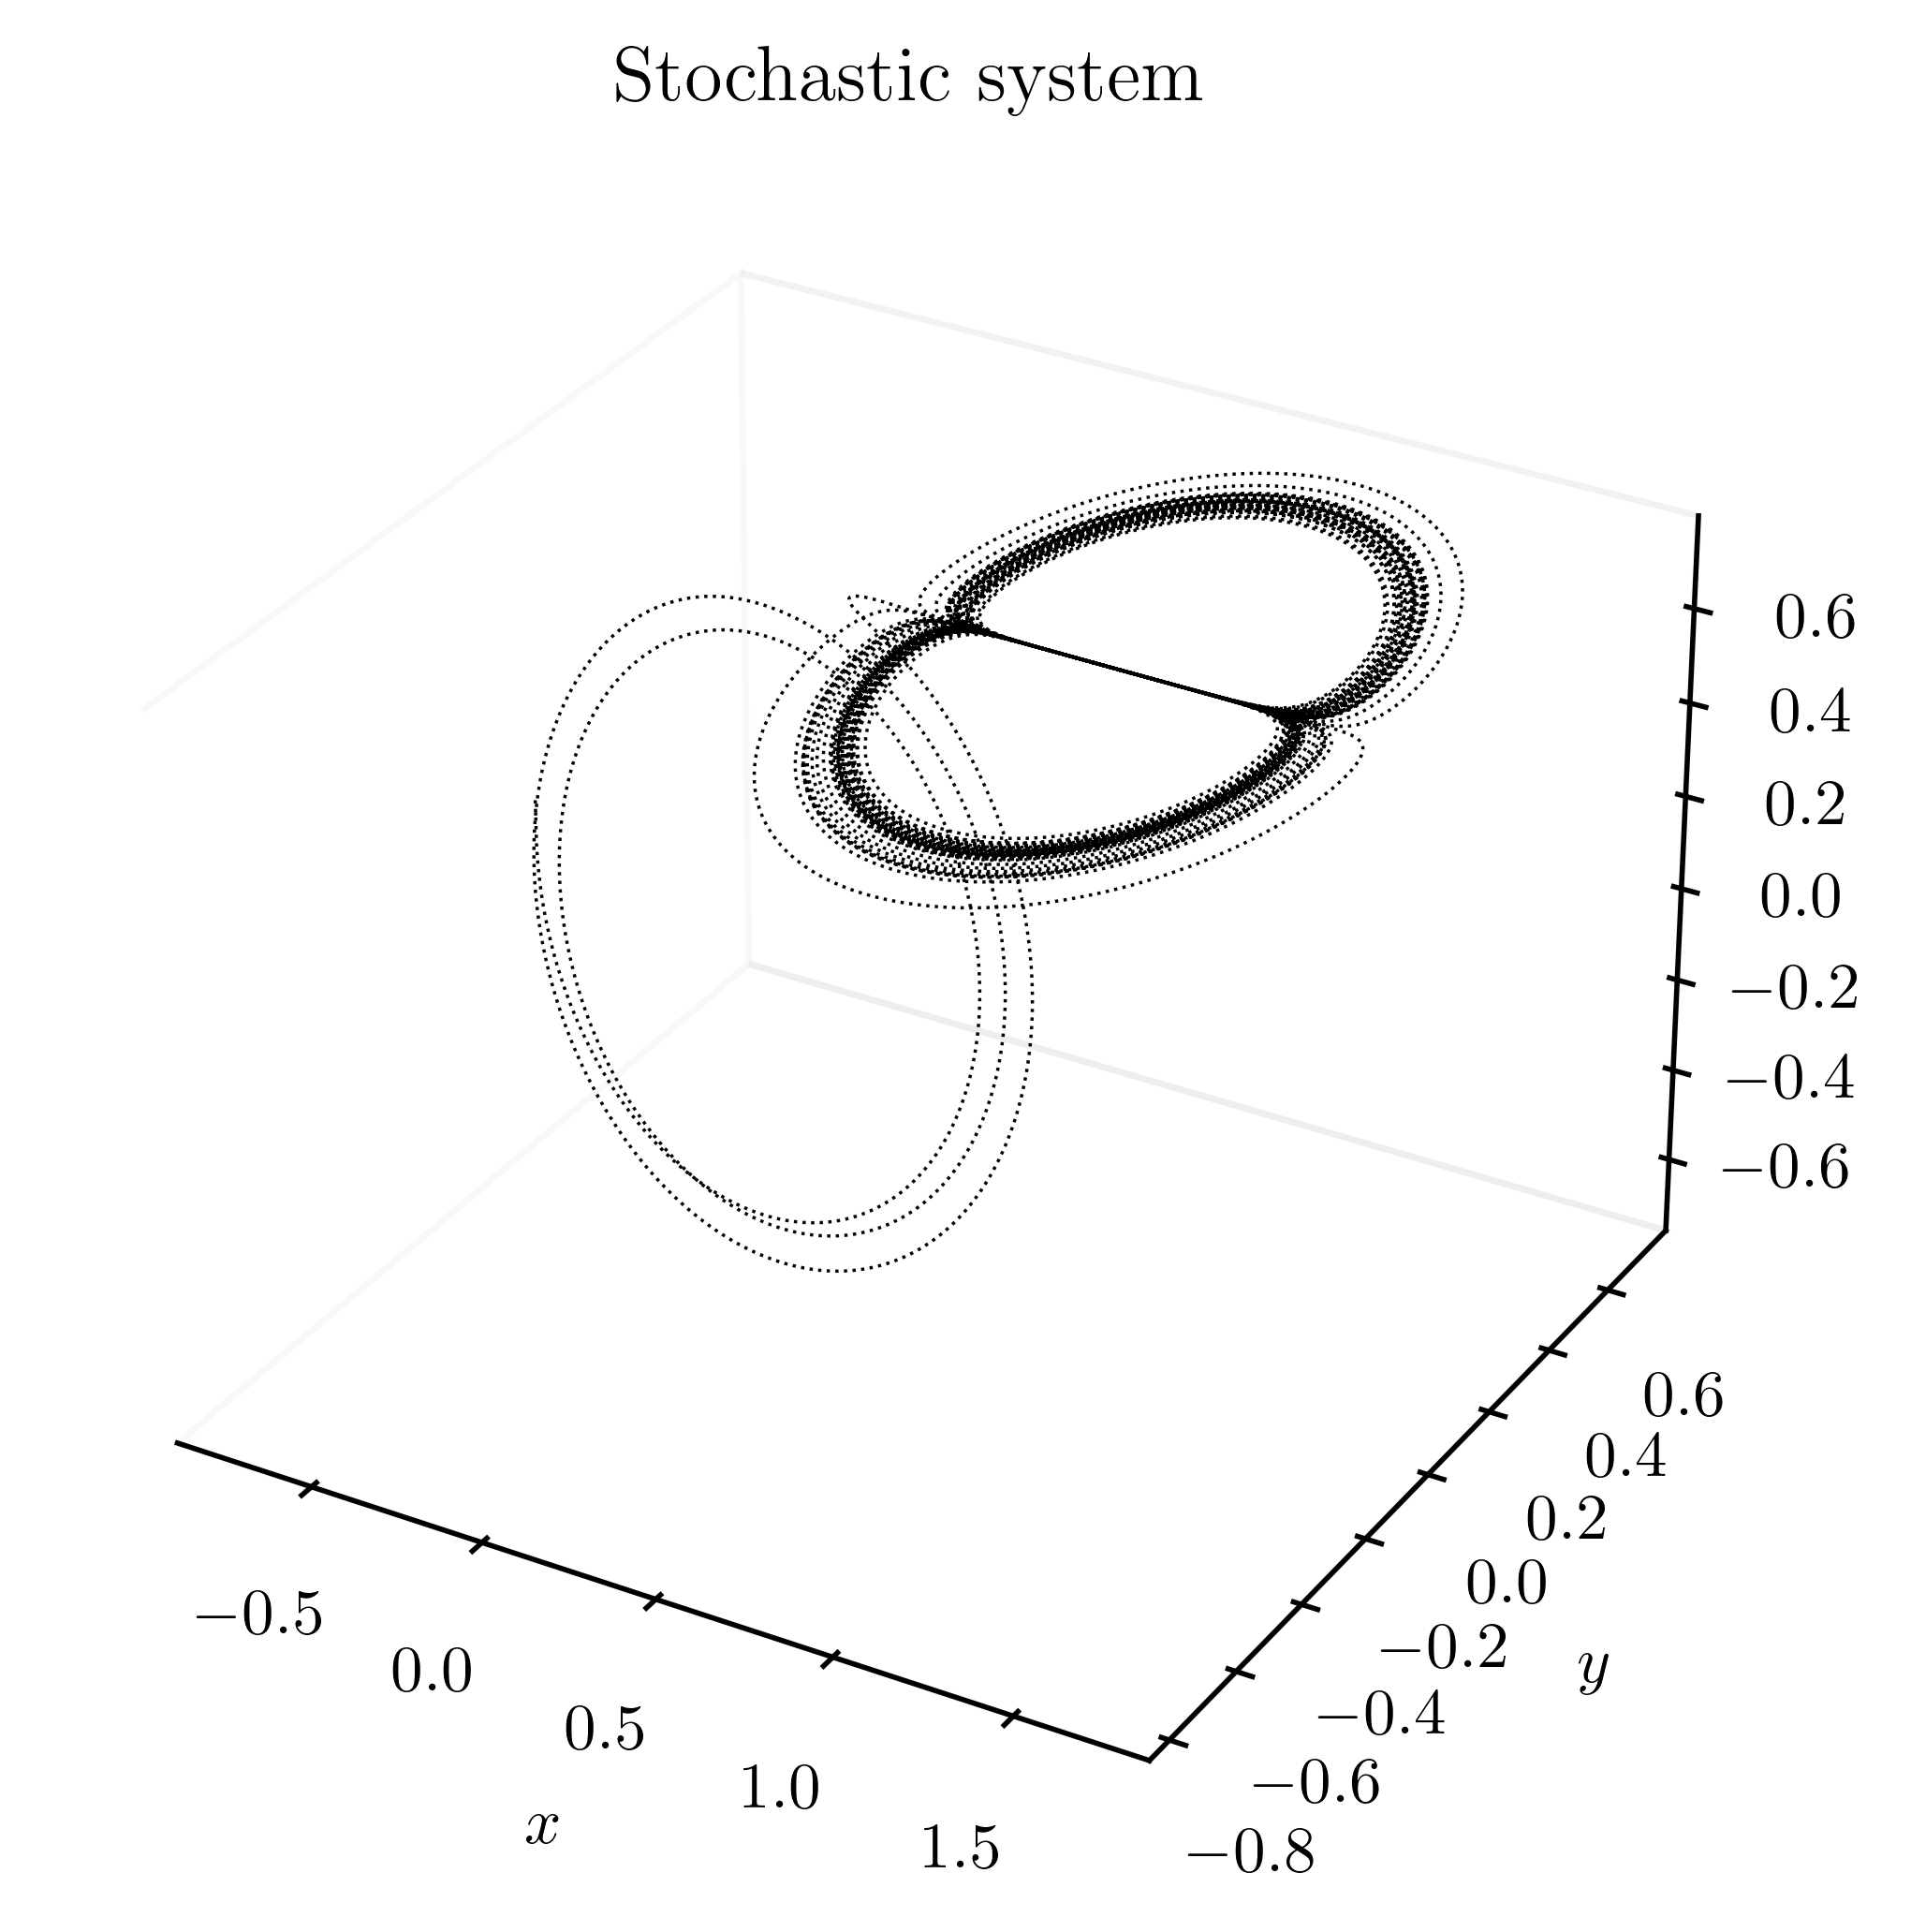

In [6]:
'''Simulation of stochastic system'''

ε = µ*0.001
X_stoch = np.zeros((N+1, 3))
X_stoch[0, :] = X0_3

for i in range(N):
    X_stoch[i+1, :] = X_stoch[i, :] + dynamics(X_stoch[i, :], dt, µ, δ, ε)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot3D(X_stoch[:, 0], X_stoch[:, 1], X_stoch[:, 2], color='black', linewidth=0.5, linestyle='dotted')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_zlabel('$z$')
ax2.set_title('Stochastic system')
ax2.grid(False)
turn_off_pane_fills(ax2)
fig2.savefig(directory + 'stochastic_system.pdf', bbox_inches='tight')



In [87]:
''' Generate Stochastic data for estimating the invariant density'''

datadir = 'data/'
for i in range(500):
    X = np.zeros((N+1, 3))
    X0 = np.random.uniform(low=-1.0, high=1.0, size=3)
    X[0, :] = X0
    for j in range(N):
        X[j+1, :] = X[j, :] + dynamics(X[j, :], dt, µ, δ, ε)
    np.save(datadir + f'X_{i}.npy', X)

In [ ]:
''' Load the generated data '''

data_matrix = np.zeros((500, N+1, 3))
for j in range(500):
    data_matrix[j,:,:] = np.load(datadir+f'X_{j}.npy')